In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df_reviews = pd.read_csv('G:\\PI MLOps - STEAM\\Data\\australian_user_reviews_ok.csv')
df_items = pd.read_csv('G:\\PI MLOps - STEAM\\Data\\data_users_items_ok.csv')
df_steam = pd.read_csv('G:\\PI MLOps - STEAM\\Data\\steam_games_ok.csv')

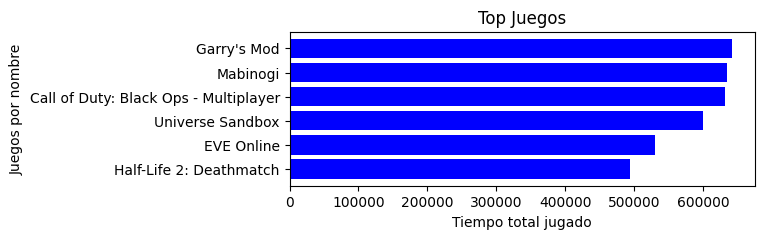

In [26]:
#Los juegos con mayor tiempo jugado
top_playtime = df_items.sort_values(by='playtime_forever', ascending=False).head(10)

# Creamos un gráfico de barras para visualizar el top 10 de juegos con mas horas jugadas
plt.figure(figsize=(6, 2))  
plt.barh(top_playtime['item_name'], top_playtime['playtime_forever'], color='blue')
plt.xlabel('Tiempo total jugado')  
plt.ylabel('Juegos por nombre')         
plt.title('Top Juegos') 
plt.gca().invert_yaxis()  
plt.show()

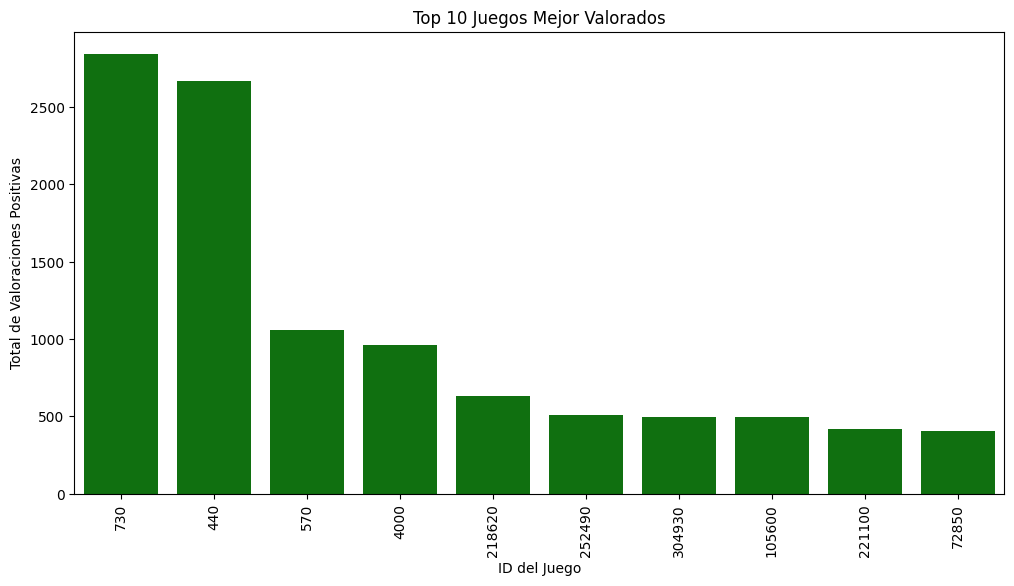

In [20]:
# Juegos mas valorados
# Filtramos para obtener solo los juegos con sentiment_analysis mayor a 1
df_mejor_valorados = df_reviews[df_reviews['sentiment_analysis'] > 1]
# Contamos la cantidad total de valoraciones positivas por juego
cantidad_valoraciones = df_mejor_valorados.groupby('item_id')['sentiment_analysis'].sum().reset_index()
# Ordenamos los juegos por cantidad total de valoraciones de manera descendente y tomamos los top 10
top_10_mejor_valorados = cantidad_valoraciones.sort_values(by='sentiment_analysis', ascending=False).head(10)

# Creamos un gráfico de barras para visualizar el top 10 de juegos mejor valorados
plt.figure(figsize=(12, 6))
sns.barplot(x='item_id', y='sentiment_analysis', data=top_10_mejor_valorados, color='green', order=top_10_mejor_valorados['item_id'])
plt.xticks(rotation=90)
plt.xlabel('ID del Juego')
plt.ylabel('Total de Valoraciones Positivas')
plt.title('Top 10 Juegos Mejor Valorados')

plt.show()

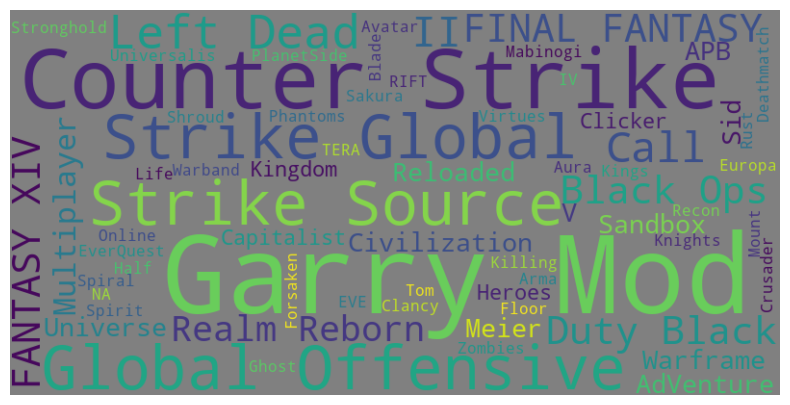

In [23]:
# Nube de palabras para los títulos de Video Juegos
top_playtime = df_items.sort_values(by='playtime_forever', ascending=False).head(100)
title_wordcloud = WordCloud(width=800, height=400, background_color='grey').generate(' '.join(top_playtime['item_name']))
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

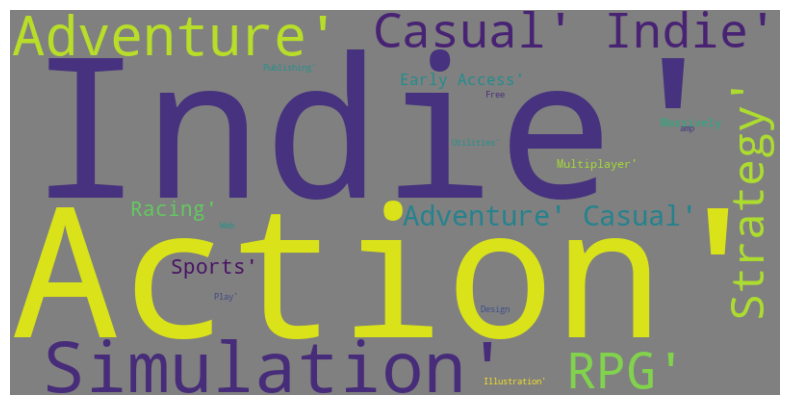

In [25]:
# Nube de palabras para los generos de Video Juegos
top_genero = df_steam.sort_values(by='playtime_forever', ascending=False).head(100)
title_wordcloud = WordCloud(width=800, height=400, background_color='grey').generate(' '.join(top_genero['genres']))
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
tipos_de_datos = df_steam.dtypes
print(tipos_de_datos)

genres              object
app_name            object
release_date         int64
tags                object
id                   int64
playtime_forever     int64
dtype: object


In [40]:
from fastapi import FastAPI, HTTPException
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Endpoint de recomendación de juegos Item-Item

In [56]:

def recomendacion_juego(product_id: int):
    # Cargar el conjunto de datos de juegos de Steam
    steamGames = pd.read_csv('G:\\PI MLOps - STEAM\\Data\\steam_games_ok.csv')
    # Seleccionar el juego de referencia por su ID
    target_game = steamGames[steamGames['id'] == product_id]
    # Verificar si el juego de referencia existe

    if target_game.empty:
        return {"message": "No se encontró el juego de referencia."}
    
    # Combinar las columnas de 'tags' y 'genres' del juego de referencia en una cadena
    target_game_tags_and_genres = ' '.join(target_game['tags'].fillna('').astype(str) + ' ' + target_game['genres'].fillna('').astype(str))
    # Inicializar el vectorizador TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    # Inicializar la variable de similitud del coseno fuera del bucle
    similarity_scores = None

    # Iterar a través del conjunto de datos en "chunks/fragnmentos"
    for chunk in pd.read_csv('G:\\PI MLOps - STEAM\\Data\\steam_games_ok.csv', chunksize=100):
        # Combinar las columnas de 'tags' y 'genres' de cada "chunk" en una lista
        chunk_tags_and_genres = chunk['tags'].fillna('').astype(str) + ' ' + chunk['genres'].fillna('').astype(str)
        games_to_compare = [target_game_tags_and_genres] + chunk_tags_and_genres.tolist()
        # Aplicar la vectorización TF-IDF a la lista de juegos
        tfidf_matrix = tfidf_vectorizer.fit_transform(games_to_compare)
        # Calcular la similitud del coseno entre los juegos

        if similarity_scores is None:
            similarity_scores = cosine_similarity(tfidf_matrix)
        else:
            similarity_scores = cosine_similarity(tfidf_matrix)

    # Verificar si se calcularon las puntuaciones de similitud
    if similarity_scores is not None:
        # Obtener los índices de juegos similares ordenados por similitud descendente
        similar_games_indices = similarity_scores[0].argsort()[::-1]
        # Número de recomendaciones a devolver
        num_recommendations = 5
        # Seleccionar los juegos recomendados y almacenarlos en un DataFrame
        recommended_games = steamGames.loc[similar_games_indices[1:num_recommendations + 1]]
        # Formatear los resultados como un diccionario de registros
        return recommended_games[['app_name']].to_dict(orient='records')
    
    # Mensaje en caso de que no se encontraran juegos similares
    return {"message": "No se encontraron juegos similares."}

In [65]:
resultado_ejemplo = recomendacion_juego(105600)
print(resultado_ejemplo)

[{'app_name': 'Real Pool 3D - Poolians'}, {'app_name': 'Ironbound'}, {'app_name': 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition'}, {'app_name': 'Battle Royale Trainer'}, {'app_name': 'SNOW - All Access Legend Pass'}]


Endpoint de recomandacion de juegos user-item

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [10]:
df_reviews

,user_id,sentiment_analysis,item_id,recommend,año_posted
0,76561197970982479,2,1250,1,2011
1,js41637,2,251610,1,2014
2,evcentric,2,248820,1,Sin dato
3,doctr,2,250320,1,2013
4,maplemage,1,211420,1,2014
...,...,...,...,...,...
25453,76561198306599751,2,261030,1,Sin dato
25454,Ghoustik,1,730,1,Sin dato
25455,76561198310819422,2,570,1,Sin dato
25456,76561198312638244,2,233270,1,Sin dato


In [24]:
def recomendacion_usuario(user_id: str):
    # Cargar el conjunto de datos de juegos de Steam
    steamGames = pd.read_csv('G:\\PI MLOps - STEAM\\Data\\australian_user_reviews_ok.csv')
    # Cargar el conjunto de datos que contiene 'tags' y 'genres'
    tags_genres_data = pd.read_csv('G:\\PI MLOps - STEAM\\Data\\steam_games_ok.csv')    
    # Verificar si el conjunto de datos contiene las columnas necesarias
    required_columns = ['user_id', 'item_id']
    if not all(column in steamGames.columns for column in required_columns):
        return {"message": "El conjunto de datos de juegos de Steam no contiene todas las columnas necesarias."}

    # Filtrar las interacciones del usuario especificado
    user_interactions = steamGames[steamGames['user_id'] == user_id]
    
    # Verificar si hay interacciones para el usuario
    if user_interactions.empty:
        return {"message": f"No hay interacciones registradas para el usuario {user_id}."}

    # Fusionar DataFrames utilizando la columna 'item_id'
    merged_data = pd.merge(user_interactions, tags_genres_data, left_on='item_id', right_on='id', how='inner')
    
    # Verificar si hay datos fusionados
    if merged_data.empty:
        return {"message": f"No se encontraron datos para el usuario {user_id}."}

    # Combinar las columnas de 'tags' y 'genres' de los juegos del usuario en una cadena
    user_games_tags_and_genres = ' '.join(merged_data['tags'].fillna('').astype(str) + ' ' + merged_data['genres'].fillna('').astype(str))    
    # Inicializar el vectorizador TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    similarity_scores = None

    # Iterar a través del conjunto de datos en "chunks/fragnmentos"
    for chunk in pd.read_csv('G:\\PI MLOps - STEAM\\Data\\australian_user_reviews_ok.csv', chunksize=100):
        # Fusionar el chunk con el DataFrame de 'tags' y 'genres'
        chunk = pd.merge(chunk, tags_genres_data, left_on='item_id', right_on='id', how='inner')
        # Combinar las columnas de 'tags' y 'genres' de cada "chunk" en una lista
        chunk_tags_and_genres = chunk['tags'].fillna('').astype(str) + ' ' + chunk['genres'].fillna('').astype(str)
        games_to_compare = [user_games_tags_and_genres] + chunk_tags_and_genres.tolist()        
        # Aplicar la vectorización TF-IDF a la lista de juegos
        tfidf_matrix = tfidf_vectorizer.fit_transform(games_to_compare)
        
        # Calcular la similitud del coseno entre los juegos
        if similarity_scores is None:
            similarity_scores = cosine_similarity(tfidf_matrix)
        else:
            similarity_scores = cosine_similarity(tfidf_matrix)

    # Verificar si se calcularon las puntuaciones de similitud
    if similarity_scores is not None:
        # Obtener los índices de juegos similares ordenados por similitud descendente
        similar_games_indices = similarity_scores[0].argsort()[::-1]
        # Número de recomendaciones a devolver
        num_recommendations = 5
        # Seleccionar los juegos recomendados y almacenarlos en un DataFrame
        recommended_games = tags_genres_data.loc[similar_games_indices[1:num_recommendations + 1]]
        # Formatear los resultados como un diccionario de registros
        return recommended_games[['app_name']].to_dict(orient='records')

    # Mensaje en caso de que no se encontraran juegos similares
    return {"message": "No se encontraron juegos similares para el usuario."}


In [26]:
resultado_ejemplo = recomendacion_usuario('maplemage')
print(resultado_ejemplo)

[{'app_name': 'Vaporwave Simulator'}, {'app_name': 'Bitcoin Clicker'}, {'app_name': 'RACE - The WTCC Game'}, {'app_name': 'Civilization IV®: Warlords'}, {'app_name': 'Advent Rising'}]


In [ ]:
'''from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Supongamos que tienes un DataFrame llamado 'df' con columnas 'user_id', 'item_id', y 'rating'

# Paso 1: División de Datos
train_data, test_data = train_test_split(df_reviews, test_size=0.2, random_state=42)

# Paso 2: Creación del Modelo
model = NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(train_data[['user_id', 'item_id']])

# Paso 3: Generación de Recomendaciones
label_encoder = LabelEncoder()
df_reviews['user_id'] = label_encoder.fit_transform(df_reviews['user_id'])
user_id_to_predict = 'maplemage'  # ID del usuario para el que quieres hacer recomendaciones
user_items = df_reviews[df_reviews['user_id'] == user_id_to_predict][['user_id', 'item_id']]

# Encuentra los vecinos más cercanos
distances, indices = model.kneighbors(user_items)

# Haz recomendaciones para el usuario basado en los vecinos más cercanos
recommended_items = set()
for index in indices.flatten():
    recommended_items.update(set(df_reviews[df_reviews['user_id'] == index]['item_id']))

# Filtra ítems ya vistos por el usuario
recommended_items -= set(user_items['item_id'])

print("Recomendaciones:", recommended_items)'''


In [43]:
'''from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convertir user_id a números usando LabelEncoder
label_encoder = LabelEncoder()
df_reviews['user_id'] = label_encoder.fit_transform(df_reviews['user_id'])

# División de Datos
train_data, test_data = train_test_split(df_reviews, test_size=0.2, random_state=42)

# Creación del Modelo
model = NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(train_data[['user_id', 'item_id']])

# Generación de Recomendaciones
user_id_to_predict = 18521  # ID del usuario para el que quieres hacer recomendaciones
# Convertir user_id del usuario a predecir
user_id_to_predict_encoded = label_encoder.transform([user_id_to_predict])[0]
user_items = df_reviews[df_reviews['user_id'] == user_id_to_predict_encoded][['user_id', 'item_id']]

# Encuentra los vecinos más cercanos
distances, indices = model.kneighbors(user_items)

# Haz recomendaciones para el usuario basado en los vecinos más cercanos
recommended_items = set()
for index in indices.flatten():
    # Convertir user_id de los vecinos de nuevo a cadenas
    neighbor_user_id = label_encoder.inverse_transform([index])[0]
    recommended_items.update(set(df_reviews[df_reviews['user_id'] == neighbor_user_id]['item_id']))

# Filtra ítems ya vistos por el usuario
recommended_items -= set(user_items['item_id'])

# Mapea IDs de juego a nombres de juego
recommended_game_names = df_steam[df_steam['id'].isin(recommended_items)]['app_name'].tolist()

print("Recomendaciones:", recommended_game_names)'''


Recomendaciones: ['Kerbal Space Program', 'Europa Universalis IV', 'PlanetSide 2', 'Gotham City Impostors Free to Play', 'BioShock® 2']


In [86]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def generar_recomendaciones(user_id_to_predict: int):
    # Convertir user_id a números usando LabelEncoder
    label_encoder = LabelEncoder()
    df_reviews['user_id'] = label_encoder.fit_transform(df_reviews['user_id'])
    # División de Datos
    train_data, test_data = train_test_split(df_reviews, test_size=0.2, random_state=42)
    # Creación del Modelo
    model = NearestNeighbors(n_neighbors=5, metric='cosine')
    model.fit(train_data[['user_id', 'item_id']])
    # Convertir user_id del usuario a predecir
    user_id_to_predict_encoded = label_encoder.transform([user_id_to_predict])[0]
    user_items = df_reviews[df_reviews['user_id'] == user_id_to_predict_encoded][['user_id', 'item_id']]
    # Encuentra los vecinos más cercanos
    distances, indices = model.kneighbors(user_items)
    # Haz recomendaciones para el usuario basado en los vecinos más cercanos
    recommended_items = set()

    for index in indices.flatten():
        # Convertir user_id de los vecinos de nuevo a cadenas
        neighbor_user_id = label_encoder.inverse_transform([index])[0]
        recommended_items.update(set(df_reviews[df_reviews['user_id'] == neighbor_user_id]['item_id']))

    # Filtra ítems ya vistos por el usuario
    recommended_items -= set(user_items['item_id'])
    # Mapea IDs de juego a nombres de juego
    recommended_game_names = df_steam[df_steam['id'].isin(recommended_items)]['app_name'].tolist()

    return recommended_game_names



In [87]:
# Ejemplo de uso
user_id_to_predict = 20156  # Sustituye esto por el user_id que desees predecir
recomendaciones = generar_recomendaciones(user_id_to_predict)
print("Recomendaciones:", recomendaciones)

Recomendaciones: ['fault - milestone two side:above', "Five Nights at Freddy's 2", 'Yet Another Zombie Defense', 'Goat Simulator']


In [90]:
'''from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def generar_recomendaciones2(user_id_to_predict: int):
    # Convertir user_id a números usando LabelEncoder
    label_encoder = LabelEncoder()
    df_reviews['user_id'] = label_encoder.fit_transform(df_reviews['user_id'])
    # División de Datos
    train_data, test_data = train_test_split(df_reviews, test_size=0.2, random_state=42)
    # Creación del Modelo
    model = NearestNeighbors(n_neighbors=5, metric='cosine')
    model.fit(train_data[['user_id', 'item_id']])
    # Convertir user_id del usuario a predecir
    user_id_to_predict_encoded = label_encoder.transform([user_id_to_predict])[0]
    user_items = df_reviews[df_reviews['user_id'] == user_id_to_predict_encoded][['user_id', 'item_id']]
    # Encuentra los vecinos más cercanos
    distances, indices = model.kneighbors(user_items)
    # Haz recomendaciones para el usuario basado en los vecinos más cercanos
    recommended_items = set()

    for index in indices.flatten():
        # Convertir user_id de los vecinos de nuevo a cadenas
        neighbor_user_id = label_encoder.inverse_transform([index])[0]
        # Filtrar juegos recomendados por el vecino
        neighbor_recommendations = df_reviews[df_reviews['user_id'] == neighbor_user_id]['recommend'].tolist()
        recommended_items.update(set(df_reviews[(df_reviews['user_id'].isin(neighbor_recommendations)) & (df_reviews['recommend'] == 1)]['item_id']))

    # Filtra ítems ya vistos por el usuario
    recommended_items -= set(user_items['item_id'])
    # Mapea IDs de juego a nombres de juego
    recommended_game_names = df_steam[df_steam['id'].isin(recommended_items)]['app_name'].tolist()

    return recommended_game_names'''


In [108]:
'''# Ejemplo de uso
user_id_to_predict = 12214  # Sustituye esto por el user_id que desees predecir
recomendaciones = generar_recomendaciones2(user_id_to_predict)
print("Recomendaciones:", recomendaciones)
'''

Recomendaciones: ['Killing Floor', 'Team Fortress 2']


In [ ]:
'''from sklearn.metrics import precision_score, recall_score

# Filtras el conjunto de prueba para obtener las interacciones del usuario en el conjunto de prueba
interacciones_usuario_prueba = test_data[test_data['user_id'] == user_id_to_predict]
print(len(interacciones_usuario_prueba))
# Conviertes las interacciones del usuario en el conjunto de prueba a una lista de juegos que realmente le gustaron
juegos_gustados_usuario_prueba = interacciones_usuario_prueba['item_id'].tolist()

# Asegúrate de que haya al menos 1 juego gustado por el usuario en el conjunto de prueba
if len(juegos_gustados_usuario_prueba) == 0:
    print("El usuario no tiene juegos gustados en el conjunto de prueba.")
else:
    # Calcula las recomendaciones solo si hay juegos gustados en el conjunto de prueba
    recomendaciones = generar_recomendaciones(user_id_to_predict)

    # Verifica que haya al menos 1 recomendación
    if len(recomendaciones) == 0:
        print("El modelo no generó recomendaciones.")

    else:
        # Asegúrate de que ambas listas tengan el mismo tamaño antes de calcular las métricas
        precision = precision_score(juegos_gustados_usuario_prueba[:len(recomendaciones)], recomendaciones, average='micro')
        recall = recall_score(juegos_gustados_usuario_prueba[:len(recomendaciones)], recomendaciones, average='micro')

        # Imprime los resultados
        print(f'Precisión: {precision}')
        print(f'Exhaustividad: {recall}')'''



In [1]:
# funcion para comprimir con gzip
import gzip
import shutil

def comprimir_a_gzip(archivo_entrada, archivo_salida):
    with open(archivo_entrada, 'rb') as f_in:
        with gzip.open(archivo_salida, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [2]:
archivo_csv = 'G:\\PI MLOps - STEAM\\Data\\data_users_items_ok.csv'
archivo_gzip = 'G:\\PI MLOps - STEAM\\Data\\data_users_items_ok.csv.gz'

comprimir_a_gzip(archivo_csv, archivo_gzip)

In [ ]:
# funcion para descomprimir un gz

import gzip
import pandas as pd

def leer_csv_gzip(archivo_gzip):
    with gzip.open(archivo_gzip, 'rt') as f:
        # 'rt' indica que el archivo está en modo de texto
        df = pd.read_csv(f)
    return df

# Ejemplo de uso
archivo_gzip = 'G:\\PI MLOps - STEAM\\Data\\data_users_items_ok.csv.gz'
datos = leer_csv_gzip(archivo_gzip)

# Ahora 'datos' es un DataFrame de pandas con el contenido del archivo CSV
